In [1]:
!pip install open3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.1 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [2]:
import numpy as np
import cv2, PIL, os
from cv2 import aruco
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from IPython.display import Image
import glob
from google.colab.patches import cv2_imshow
import open3d as o3d

In [3]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

### Camera calibration

In [ ]:
import cv2
import numpy as np
import cv2.aruco as aruco
import os
import glob
import matplotlib.pyplot as plt

def create_charuco_board(squaresX, squaresY, square_length, marker_length, aruco_dict_type):
    aruco_dict = aruco.getPredefinedDictionary(aruco_dict_type)
    board = aruco.CharucoBoard((squaresX, squaresY), square_length, marker_length, aruco_dict)
    return board

def detect_charuco_corners(image, board, aruco_dict):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    corners, ids, rejected = aruco.detectMarkers(gray, aruco_dict)
    if ids is not None:
        corners, ids, rejected, recovered = aruco.refineDetectedMarkers(gray, board, corners, ids, rejected)
        retval, charuco_corners, charuco_ids = aruco.interpolateCornersCharuco(corners, ids, gray, board)
        if charuco_corners is not None and charuco_ids is not None and len(charuco_corners) > 3:
            return charuco_corners, charuco_ids, corners, ids
    return None, None, None, None



def load_images_from_folder(folder, board, aruco_dict):
    all_corners = []
    all_ids = []
    all_objpoints = []
    img_size = None

    images = glob.glob(os.path.join(folder, '*.JPG'))
    print(f"Found {len(images)} images in {folder}.")  # Debug statement

    for img_path in images:
        image = cv2.imread(img_path)
        if image is None:
            print(f"Failed to load image: {img_path}")  # Debug statement
            continue
        if img_size is None:
            img_size = image.shape[:2]

        charuco_corners, charuco_ids, corners, ids = detect_charuco_corners(image, board, aruco_dict)
        if charuco_corners is not None and charuco_ids is not None:
            all_corners.append(charuco_corners)
            all_ids.append(charuco_ids)
            obj_points = board.getChessboardCorners()
            selected_objpoints = obj_points[charuco_ids.flatten()]
            all_objpoints.append(selected_objpoints)
            # Draw detected markers and charuco corners
            aruco.drawDetectedMarkers(image, corners, ids)
            aruco.drawDetectedCornersCharuco(image, charuco_corners, charuco_ids)
            # Display the image using matplotlib
            plt.figure(figsize=(10, 10))
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.title('Detected Charuco corners and markers')
            plt.axis('off')
            plt.show()
        else:
            print(f"No corners detected in image: {img_path}")  # Debug statement

    print(f"Successfully detected corners in {len(all_corners)} images.")  # Debug statement
    return all_corners, all_ids, all_objpoints, img_size



def calibrate_camera(all_corners, all_ids, board, image_size):
    camera_matrix, dist_coeffs = None, None
    if len(all_corners) > 0:
        calibration, camera_matrix, dist_coeffs, rvecs, tvecs = aruco.calibrateCameraCharuco(
            all_corners, all_ids, board, image_size, None, None)
    return camera_matrix, dist_coeffs

def stereo_calibrate(cameraMatrix1, distCoeffs1, cameraMatrix2, distCoeffs2, objpoints1, corners1, corners2, objpoints2, img_size):
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-5)
    flags = cv2.CALIB_FIX_INTRINSIC
    retval, cameraMatrix1, distCoeffs1, cameraMatrix2, distCoeffs2, R, T, E, F = cv2.stereoCalibrate(
        objpoints1, corners1, corners2,
        cameraMatrix1, distCoeffs1, cameraMatrix2, distCoeffs2,
        img_size, criteria=criteria, flags=flags
    )
    return retval, cameraMatrix1, distCoeffs1, cameraMatrix2, distCoeffs2, R, T, E, F

def prepare_data_for_calibration(all_corners, all_ids, all_objpoints):
    # Filter out any detections where corners or object points are missing
    valid_corners = []
    valid_objpoints = []

    for corners, ids, objpoints in zip(all_corners, all_ids, all_objpoints):
        if len(corners) > 0 and len(objpoints) > 0 and len(ids) > 0:
            valid_corners.append(corners)
            valid_objpoints.append(objpoints)

    return valid_corners, valid_objpoints

def filter_matched_data(corners1, objpoints1, corners2, objpoints2):
    # Ensure both cameras have the same number of detections and corresponding points
    if len(corners1) != len(corners2):
        min_length = min(len(corners1), len(corners2))
        corners1 = corners1[:min_length]
        objpoints1 = objpoints1[:min_length]
        corners2 = corners2[:min_length]
        objpoints2 = objpoints2[:min_length]

    # Further ensure that each set of corners corresponds to the same set of object points
    matched_corners1 = []
    matched_objpoints1 = []
    matched_corners2 = []
    matched_objpoints2 = []

    for i in range(len(corners1)):
        if len(corners1[i]) == len(corners2[i]):
            matched_corners1.append(corners1[i])
            matched_objpoints1.append(objpoints1[i])
            matched_corners2.append(corners2[i])
            matched_objpoints2.append(objpoints2[i])

    return matched_corners1, matched_objpoints1, matched_corners2, matched_objpoints2


In [ ]:
def save_calibration_parameters(filename, camera_matrix, dist_coeffs):
    np.savez(filename, camera_matrix=camera_matrix, dist_coeffs=dist_coeffs)
    with open(filename + '.txt', 'w') as f:
        f.write(f"Camera matrix:\n{camera_matrix}\n")
        f.write(f"Distortion coefficients:\n{dist_coeffs}\n")

In [ ]:
# Create charuco board
board = create_charuco_board(5, 7, 0.04, 0.02, aruco.DICT_6X6_50)
# Create aruco dictionary
aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_6X6_50)


# Load calibration data from directories
all_corners1, all_ids1, all_objpoints1, img_size1 = load_images_from_folder("/content/drive/MyDrive/data/left", board, aruco_dict)
all_corners2, all_ids2, all_objpoints2, img_size2 = load_images_from_folder("/content/drive/MyDrive/data/front", board, aruco_dict)
all_corners3, all_ids3, all_objpoints3, img_size3 = load_images_from_folder("/content/drive/MyDrive/data/right", board, aruco_dict)

# Calibrate cameras
print("Processing left camera")
cameraMatrix1, distCoeffs1 = calibrate_camera(all_corners1, all_ids1, board, img_size1)
save_calibration_parameters(f'left_camera_calibration', cameraMatrix1, distCoeffs1)
print("Processing front camera")
cameraMatrix2, distCoeffs2 = calibrate_camera(all_corners2, all_ids2, board, img_size2)
save_calibration_parameters(f'front_camera_calibration', cameraMatrix2, distCoeffs2)
print("Processing right camera")
cameraMatrix3, distCoeffs3 = calibrate_camera(all_corners3, all_ids3, board, img_size3)
save_calibration_parameters(f'right_camera_calibration', cameraMatrix3, distCoeffs3)
# Check calibration results
if cameraMatrix1 is None or distCoeffs1 is None:
    print("Failed to calibrate camera 1. Exiting.")
    exit(1)

if cameraMatrix2 is None or distCoeffs2 is None:
    print("Failed to calibrate camera 2. Exiting.")
    exit(1)

if cameraMatrix3 is None or distCoeffs3 is None:
    print("Failed to calibrate camera 3. Exiting.")
    exit(1)


# Check image sizes
if img_size1 != img_size2:
    print("Warning: Image sizes do not match. Stereo calibration may be inaccurate.")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import cv2 as cv
import glob
import numpy as np


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline

<Figure size 640x480 with 0 Axes>

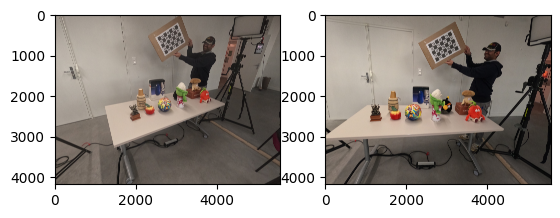

In [ ]:
imgL = cv2.imread("/content/drive/MyDrive/data/left/GOPR0858.JPG")
imgR = cv2.imread("/content/drive/MyDrive/data/front/GOPR0066.JPG")
plt.figure()
#converting BGR to RGB for plotting
disp1 = cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB)
disp2 = cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(1,2)
ax[0].imshow(disp1)
ax[1].imshow(disp2)

In [ ]:
def decompose_essential_matrix(E,K,pts1,pts2):
    [U, D, V] = np.linalg.svd(E)
    diag_arr = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 0]])
    new_E = U @ diag_arr @ V
    [U, D, V] = np.linalg.svd(new_E)
    Y = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
    R1 = - U @ Y @ V
    R2 = - U @ Y.T @ V
    t = U[:, 2].reshape(3, 1)
    R_mat = np.array([R1, R1, R2, R2])
    T_mat = np.array([t, -t, t, -t])
    P1 = np.zeros((3, 4))
    P1[:, :3] = np.eye(3)
    P1 = K @ P1
    print(R1, "\n", R2)
    for i in range(4):
        P2 = np.concatenate((R_mat[i], T_mat[i]), axis=1)
        P2 = K @ P2
        world_pts = cv2.triangulatePoints(P1, P2, pts1, pts2)
        X, Y, Z = world_pts[:3, :] / world_pts[3, :]
        Z_ = R_mat[i][2, 0] * X + R_mat[i][2, 1] * Y + R_mat[i][2, 2] * Z + T_mat[i][2]
        print(len(np.where(Z < 0)[0]), len(np.where(Z_ < 0)[0]))
        if len(np.where(Z < 0)[0]) == 0:
            R = R_mat[i]
            t = T_mat[i]
            break
    return R,t

In [ ]:
def drawlines(img1, img2, lines, pts1, pts2):
    """ Draw epipolar lines on the images """
    r, c, _ = img1.shape
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1]])
        img1 = cv2.line(img1, (x0, y0), (x1, y1), color, 1)
        img1 = cv2.circle(img1, (int(pt1[0][0]), int(pt1[0][1])), 5, color, -1)
        img2 = cv2.circle(img2, (int(pt2[0][0]), int(pt2[0][1])), 5, color, -1)
    return img1, img2

In [ ]:
# Defining the Parameter for stereoSGBM
min_disparity =  -1
max_disparity = 159
num_disparity = max_disparity - min_disparity
SADWindowSize = 5
uniqueness = 5
speckle_windows_size = 5
speckle_range = 5
P1 = 8*3*SADWindowSize**2
P2 = 32*3*SADWindowSize**2


KL = cameraMatrix1
KR = cameraMatrix2
dist_coeff = None

In [ ]:
# Convert images to grayscale
grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
image_size = grayL.shape[::-1]  # (width, height)

# Detect SIFT keypoints and descriptors
sift = cv2.SIFT_create()
kp1, desc1 = sift.detectAndCompute(grayL, None)
kp2, desc2 = sift.detectAndCompute(grayR, None)

# BFMatcher with knn
bf = cv2.BFMatcher()
matches = bf.knnMatch(desc1, desc2, k=2)

# Apply ratio test
good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)

# Extract matched keypoints
pts1 = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
pts2 = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

# Find essential matrix
E, mask = cv2.findEssentialMat(pts1, pts2, KL, method=cv2.RANSAC, prob=0.99, threshold=1.0)
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

# Recover pose
_, R, t, mask = cv2.recoverPose(E, pts1, pts2, KL)

# Stereo Rectification
R1, R2, P1, P2, _, _, _ = cv2.stereoRectify(KL, None, KR, None, image_size, R, t)

# Compute rectification maps
mapx1, mapy1 = cv2.initUndistortRectifyMap(KL, None, R1, P1, image_size, cv2.CV_32FC1)
mapx2, mapy2 = cv2.initUndistortRectifyMap(KR, None, R2, P2, image_size, cv2.CV_32FC1)

# Apply remap
rectified_imgL = cv2.remap(imgL, mapx1, mapy1, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
rectified_imgR = cv2.remap(imgR, mapx2, mapy2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

# Check if rectified images are not black
if rectified_imgL is None or rectified_imgR is None:
    print("Error: Rectified images are None")
else:
    print("Rectified images computed successfully")

K_inv = np.linalg.inv(KL)
F = K_inv.T @ E @ K_inv
print("R = {} \n t = {}".format(R,t))
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)

Rectified images computed successfully
R = [[ 0.81737541 -0.39746485  0.41703613]
 [ 0.28994903  0.90934093  0.29837667]
 [-0.49782226 -0.12296653  0.85851746]] 
 t = [[-0.90362893]
 [-0.41649899]
 [ 0.09991673]]


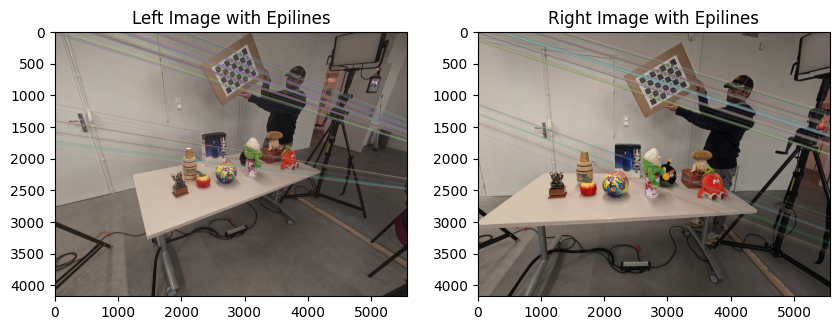

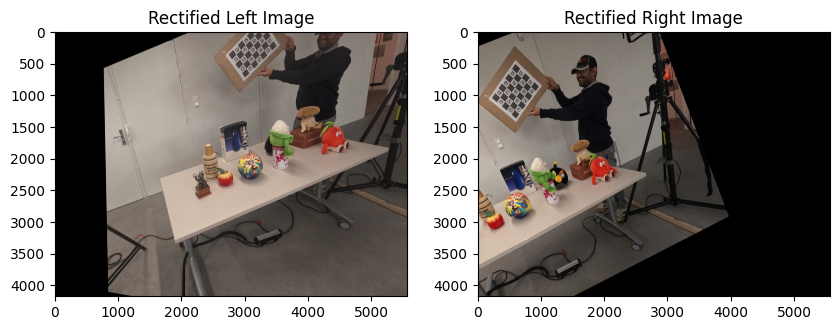

In [ ]:
# Draw epilines on the images
imgL_lines1, imgR_lines1 = drawlines(imgL.copy(), imgR.copy(), lines1, pts1, pts2)
imgR_lines2, imgL_lines2 = drawlines(imgR.copy(), imgL.copy(), lines2, pts2, pts1)

# Display images with epilines
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(cv2.cvtColor(imgL_lines1, cv2.COLOR_BGR2RGB))
plt.title('Left Image with Epilines')
plt.subplot(122)
plt.imshow(cv2.cvtColor(imgR_lines2, cv2.COLOR_BGR2RGB))
plt.title('Right Image with Epilines')
plt.show()

# Display rectified images
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(cv2.cvtColor(rectified_imgL, cv2.COLOR_BGR2RGB))
plt.title('Rectified Left Image')
plt.subplot(122)
plt.imshow(cv2.cvtColor(rectified_imgR, cv2.COLOR_BGR2RGB))
plt.title('Rectified Right Image')
plt.show()

In [ ]:
from google.colab.patches import cv2_imshow
left_matcher = cv2.StereoSGBM_create(minDisparity=min_disparity,numDisparities=num_disparity,blockSize=SADWindowSize
                               ,P1= 8*3*SADWindowSize**2,P2=32*3*SADWindowSize**2,uniquenessRatio=uniqueness,disp12MaxDiff=2,
                                speckleWindowSize=speckle_windows_size,speckleRange=speckle_range)

left_disparity = left_matcher.compute(rectified_imgL,rectified_imgR)
right_matcher = cv2.ximgproc.createRightMatcher(left_matcher)
right_disparity = right_matcher.compute(rectified_imgR,rectified_imgL)

# wls filtering
sigma = 1.5
lambda_ = 8000
wls = cv2.ximgproc.createDisparityWLSFilter(left_matcher)
wls.setLambda(lambda_)
wls.setSigmaColor(sigma)
filtered_disparity = wls.filter(left_disparity,rectified_imgL,disparity_map_right = right_disparity)
cv2.filterSpeckles(filtered_disparity,0,400,max_disparity-5)
_,filtered_disparity = cv2.threshold(filtered_disparity,0,max_disparity*16,cv2.THRESH_TOZERO)
filtered_disparity = (filtered_disparity/16).astype(np.uint8)

cv2_imshow(filtered_disparity)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
b = np.linalg.norm(t)

In [ ]:
depth_map = KL[0,0]*b / (filtered_disparity)
depth_map = depth_map.astype('uint16')
cv2_imshow(depth_map)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Reprojection matrix
Q = np.float32([[1,0,0,-KL[0,2]],
                [0,1,0,-KL[1,2]],
                [0,0,0,KL[0,0]],
                [0,0,-1/b,(KL[0,2]-KR[0,2])/b]])


points = cv2.reprojectImageTo3D(filtered_disparity,Q)
points = points.reshape(-1,3)
color = rectified_imgL.reshape(-1,3)
color = np.flip(color,axis = 1)/255
xyzrbg = np.concatenate((points,color),axis=1)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyzrbg[:,:3])
pcd.colors = o3d.utility.Vector3dVector(xyzrbg[:,3:])
o3d.io.write_point_cloud('/content/drive/MyDrive/great_data4.ply',pcd)
o3d.visualization.draw_geometries([pcd])

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


In [ ]:
import open3d as o3d
import numpy as np

# Load the original point cloud
pcd = o3d.io.read_point_cloud('/content/drive/MyDrive/great_data.ply')

# Get the total number of points in the point cloud
num_points = len(pcd.points)

# Check if the number of points is greater than 1 million
if num_points > 2_000_000:
    # Randomly sample 1 million points
    indices = np.random.choice(num_points, 5_000_000, replace=False)
    downsampled_pcd = pcd.select_by_index(indices)
else:
    downsampled_pcd = pcd

# Save the downsampled point cloud
o3d.io.write_point_cloud('/content/drive/MyDrive/bruh.ply', downsampled_pcd)

# Visualize the downsampled point cloud
o3d.visualization.draw_geometries([downsampled_pcd])

[Open3D WARNING] Read PLY failed: unable to open file: /content/drive/MyDrive/great_data.ply
[Open3D WARNING] Write PLY failed: point cloud has 0 points.
[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


#2.5D Visualize

[Open3D WARNING] Read PLY failed: unable to open file: /content/drive/MyDrive/downsampled.ply


ValueError: zero-size array to reduction operation minimum which has no identity

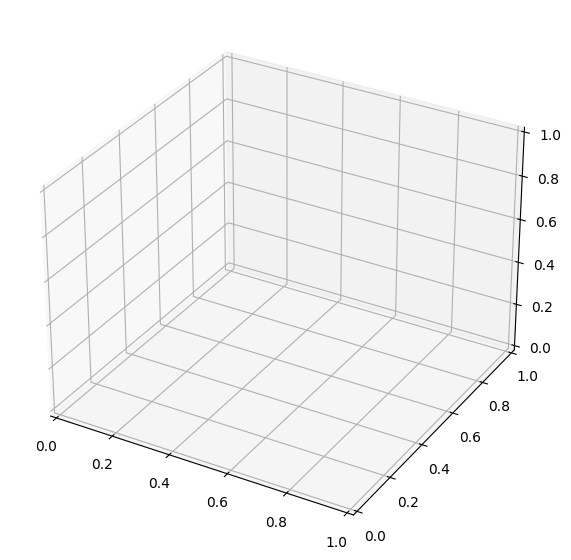

In [ ]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

# Load the point cloud
pcd = o3d.io.read_point_cloud('/content/drive/MyDrive/downsampled.ply')


# Convert point cloud to numpy array
points = np.asarray(pcd.points)
colors = np.asarray(pcd.colors)

# Plot the 2.5D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Normalize z values for color mapping
z_values = points[:, 2]
norm = plt.Normalize(z_values.min(), z_values.max())

# Scatter plot
scatter = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=z_values, cmap='viridis', marker='o', s=1, alpha=0.5)

# Add color bar
cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Depth')

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title('2.5D Point Cloud Visualization')
plt.show()

In [ ]:
import numpy as np
import cv2 as cv
import glob
import open3d as o3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def calibrate_camera(images_folder):
    images_names = sorted(glob.glob(images_folder))
    images = [cv.imread(imname, 1) for imname in images_names]

    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    rows, columns, world_scaling = 4, 6, 1.0

    objp = np.zeros((rows * columns, 3), np.float32)
    objp[:, :2] = np.mgrid[0:rows, 0:columns].T.reshape(-1, 2)
    objp *= world_scaling

    objpoints, imgpoints = [], []

    for frame in images:
        gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        ret, corners = cv.findChessboardCorners(gray, (rows, columns), None)
        if ret:
            corners = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            imgpoints.append(corners)
            objpoints.append(objp)

    ret, camera_matrix, dist_coeffs, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return camera_matrix, dist_coeffs, rvecs, tvecs

def get_stereo_3d_points(img1, img2, calib1, calib2):
    camera_matrix1, dist_coeffs1, rvecs1, tvecs1 = calib1
    camera_matrix2, dist_coeffs2, rvecs2, tvecs2 = calib2

    img1 = cv.undistort(img1, camera_matrix1, dist_coeffs1, None, camera_matrix1)
    img2 = cv.undistort(img2, camera_matrix2, dist_coeffs2, None, camera_matrix2)

    sift = cv.SIFT_create()
    kp1, des1 = sift.detectAndCompute(cv.cvtColor(img1, cv.COLOR_BGR2GRAY), None)
    kp2, des2 = sift.detectAndCompute(cv.cvtColor(img2, cv.COLOR_BGR2GRAY), None)

    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

    E, mask = cv.findEssentialMat(pts1, pts2, camera_matrix1)
    points, R, t, mask = cv.recoverPose(E, pts1, pts2, camera_matrix1)

    points_4d = cv.triangulatePoints(np.hstack((np.eye(3), np.zeros((3, 1)))), np.hstack((R, t)), pts1.T, pts2.T)
    points_3d = points_4d[:3] / points_4d[3]

    return points_3d.T

def combine_point_clouds(clouds):
    combined_cloud = np.vstack(clouds)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(combined_cloud[:, :3])
    pcd.colors = o3d.utility.Vector3dVector(combined_cloud[:, 3:] if combined_cloud.shape[1] == 6 else np.ones((combined_cloud.shape[0], 3)))
    return pcd

def main():
    front_images_folder = '/content/drive/MyDrive/data/front/*.JPG'
    right_images_folder = '/content/drive/MyDrive/data/right/*.JPG'
    left_images_folder = '/content/drive/MyDrive/data/left/*.JPG'

    front_calib = calibrate_camera(front_images_folder)
    right_calib = calibrate_camera(right_images_folder)
    left_calib = calibrate_camera(left_images_folder)

    front_images = sorted(glob.glob(front_images_folder))
    right_images = sorted(glob.glob(right_images_folder))
    left_images = sorted(glob.glob(left_images_folder))

    all_points = []

    for i in range(min(len(front_images), len(right_images), len(left_images))):
        img_front = cv.imread(front_images[i])
        img_right = cv.imread(right_images[i])
        img_left = cv.imread(left_images[i])

        points_3d_fr = get_stereo_3d_points(img_front, img_right, front_calib, right_calib)
        points_3d_fl = get_stereo_3d_points(img_front, img_left, front_calib, left_calib)

        all_points.append(points_3d_fr)
        all_points.append(points_3d_fl)

    combined_pcd = combine_point_clouds(all_points)
    o3d.io.write_point_cloud('combined_point_cloud.ply', combined_pcd)
    o3d.visualization.draw_geometries([combined_pcd])

if __name__ == '__main__':
    main()


[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.
